## Read stopwords

In [1]:
import pickle

In [2]:
sws = pickle.load(open('/home/mcb/li_lab/zwen8/data/mimic/more_stopwords.pickle', 'rb'))

In [14]:
len(sws)

1074

In [31]:
'pt' in sws

True

## Try parallize preprocessing

In [2]:
import pandas as pd
from multiprocessing import Pool
import string
from nltk.corpus import stopwords

In [16]:
datapath = r'/home/mcb/li_lab/pnair6/mimic/data/all_cohort_notes_Oct17.csv'

In [17]:
data = pd.read_csv(datapath)

In [190]:
data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICUSTAY_ID,FIRST_VENT_STARTTIME,TIME_FROM_VENT
0,316480,31916,146431.0,2112-02-23,2112-02-23 03:51:00,2112-02-23 04:03:01,Nursing,Nursing Progress Note,14419.0,NaN,"Respiratory failure, acute (not ARDS/[**Doctor...",255563.0,2112-02-22 04:05:00,23.766667
1,317750,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:22:26,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...,272695.0,2143-04-09 00:00:00,3.366667
2,317751,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:27:59,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...,272695.0,2143-04-09 00:00:00,3.366667
3,317944,29487,116532.0,2163-01-19,2163-01-19 16:06:00,2163-01-19 16:07:16,Respiratory,Respiratory Care Shift Note,16356.0,NaN,Demographics\n Day of intubation: [**2163-1-...,245788.0,2163-01-18 15:00:00,25.100000
4,318002,29487,116532.0,2163-01-20,2163-01-20 05:12:00,2163-01-20 05:12:30,Nursing,Nursing Progress Note,21336.0,NaN,No significant events overnight\n Renal fail...,245788.0,2163-01-18 15:00:00,38.200000


In [18]:
merged_data = data[['SUBJECT_ID', "HADM_ID"]].drop_duplicates()
merged_data["ALLTEXT"] = merged_data.HADM_ID.apply(lambda hadm_id: "\n".join(data[data.HADM_ID == hadm_id].TEXT))
merged_data.dropna()

,SUBJECT_ID,HADM_ID,ALLTEXT
0,31916,146431.0,"Respiratory failure, acute (not ARDS/[**Doctor..."
1,27866,109679.0,Ms. [**Known lastname 1170**] is an 83 yo F w/...
3,29487,116532.0,No significant events overnight\n Renal fail...
5,29076,193948.0,"Chief Complaint: Influenza, intubated\n 24 H..."
9,29705,161764.0,Chief Complaint: respiratory distress\n HPI...
...,...,...,...
151915,9670,129480.0,CSRU ADMIT NOTE\nPT IS A 45 YR OLD FEMALE S/P ...
151959,32327,185874.0,Respiratory Care Note\nPt received on NIV [**1...
151973,32179,102139.0,"NEURO: Pt A&Ox3, follows commands, MAE and ver..."
152006,32137,113013.0,Nursing Admit Note\nPt is a 24 yo with no past...


In [21]:
def merge_notes(hadm_id):
    return "\n".join(data[data.HADM_ID == hadm_id].TEXT)

In [40]:
def preprocess_text(text):
    # convert to lower case
    lower = text.lower()
    # remove punc
    no_punc = lower.translate(str.maketrans("", "", string.punctuation))
    # remove white space
    no_white = " ".join(no_punc.split())
    # remove numbers
    no_num = no_white.translate(str.maketrans("", "", string.digits))
    # remove stopwords
    normal_sws = list(set(stopwords.words('english')))
    more_sws = pickle.load(open('/home/mcb/li_lab/zwen8/data/mimic/more_stopwords.pickle', 'rb'))
    sws = set(normal_sws + more_sws)
    no_sw = " ".join([word for word in no_num.split() if word not in sws])
    return no_sw

In [45]:
par_merged_data = data[['SUBJECT_ID', "HADM_ID"]].drop_duplicates()
with Pool(processes=6) as pool:
    par_merged_data["ALLTEXT"] = pool.map(merge_notes, merged_data['HADM_ID'])

In [46]:
with Pool(processes=6) as pool:
    par_merged_data["PROCTEXT"] = pool.map(preprocess_text, par_merged_data["ALLTEXT"])

In [29]:
par_merged_data["PROCTEXT"].shape

(17400,)

## Pool with multiple outputs

In [30]:
from itertools import repeat

In [33]:
def multi_output_func(number1, number2, number3):
    return [number1, number2, number3], [-number1, -number2, -number3]

In [34]:
with Pool(processes=3) as pool:
    results = pool.starmap(multi_output_func, zip(range(0, 3), repeat(4), repeat(5)))

In [35]:
results

[([0, 4, 5], [0, -4, -5]),
 ([1, 4, 5], [-1, -4, -5]),
 ([2, 4, 5], [-2, -4, -5])]

In [15]:
(a, b), (c, d), (e, f) = results

In [20]:
e

[2, -2]

## Regenerate training set

In [3]:
import pandas as pd

In [1]:
note_file = r'/home/mcb/li_lab/pnair6/mimic/data/all_cohort_notes_Oct17.csv'
validation_file = r'/home/mcb/li_lab/zwen8/data/mimic/d2_phy_nurse_48/validation_notes.txt'
test_file = r'/home/mcb/li_lab/zwen8/data/mimic/d2_phy_nurse_48/test_notes.txt'

In [8]:
all_notes = pd.read_csv(note_file)
validation_notes = pd.read_csv(validation_file, header=None)
test_notes = pd.read_csv(test_file, header=None)

In [5]:
all_notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICUSTAY_ID,FIRST_VENT_STARTTIME,TIME_DIFF,TIME_FROM_VENT
0,316480,31916,146431.0,2112-02-23,2112-02-23 03:51:00,2112-02-23 04:03:01,Nursing,Nursing Progress Note,14419.0,NaN,"Respiratory failure, acute (not ARDS/[**Doctor...",255563.0,2112-02-22 04:05:00,23.0,23.766667
1,317750,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:22:26,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...,272695.0,2143-04-09 00:00:00,3.0,3.366667
2,317751,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:27:59,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...,272695.0,2143-04-09 00:00:00,3.0,3.366667
3,318002,29487,116532.0,2163-01-20,2163-01-20 05:12:00,2163-01-20 05:12:30,Nursing,Nursing Progress Note,21336.0,NaN,No significant events overnight\n Renal fail...,245788.0,2163-01-18 15:00:00,38.0,38.200000
4,318003,29487,116532.0,2163-01-20,2163-01-20 05:12:00,2163-01-20 05:12:52,Nursing,Nursing Progress Note,21336.0,NaN,No significant events overnight\n Renal fail...,245788.0,2163-01-18 15:00:00,38.0,38.200000


In [13]:
validation_notes.columns = ['SUBJECT_ID', 'HADM_ID', 'ALLTEXT', 'PROCTEXT', 'STARTTIME', 'ENDTIME', 'DURATION']
test_notes.columns = ['SUBJECT_ID', 'HADM_ID', 'ALLTEXT', 'PROCTEXT', 'STARTTIME', 'ENDTIME', 'DURATION']

In [14]:
validation_notes.head()

,SUBJECT_ID,HADM_ID,ALLTEXT,PROCTEXT,STARTTIME,ENDTIME,DURATIONA
0,31294,101974,Respiratory Therapy\nPt presents on .5 venti-m...,respiratory therapy pt presents ventimask somn...,2119-02-13 20:00:00,2119-02-16 16:01:00,68.016667
1,2917,127682,"CCU NPN 1900-0700\nS: "" My leg is sore ""\nO: ...",ccu npn leg sore arrived cath post iabp placem...,2122-07-01 13:34:00,2122-07-06 07:07:00,113.550000
2,57588,195502,TITLE:\n HPI:\n 41 yo male s/p head trauma...,title hpi yo male sp head trauma punched head ...,2192-11-25 01:59:00,2192-11-28 10:26:00,80.450000
3,30648,130000,adm. from ed @ 2130-temp 100.5-100.8 hr 90...,adm ed temp hr nr raf slopressor mg iv x slow ...,2115-08-08 20:00:00,2115-08-20 13:00:00,281.000000
4,9869,181000,SICU NPN\nS-Intubated and sedated\n\nSEE CAREV...,sicu npn sintubated sedated see carevue object...,2188-04-17 15:00:00,2188-04-24 08:00:00,161.000000


In [15]:
test_notes.head()

,SUBJECT_ID,HADM_ID,ALLTEXT,PROCTEXT,STARTTIME,ENDTIME,DURATIONA
0,12,112213,Respiratory Care:\n\nPatient remains intubated...,respiratory care patient remains intubated mec...,2104-08-08 04:20:00,2104-08-11 15:00:00,82.666667
1,115,114585,Resp Care: Pt continues intubated # 7 oett sec...,resp care pt continues intubated oett secured ...,2194-10-17 12:00:00,2194-10-19 12:00:00,48.000000
2,146,190707,BRADYCARDIA\nO: SEE FLOW SHEET FOR CLINICAL IN...,bradycardia see flow sheet clinical informatio...,2119-12-24 22:30:00,2119-12-29 14:00:00,111.500000
3,228,167764,CCU NPN\nSee FHPA from CC6 for admit details.\...,ccu npn see fhpa cc admit details pt yo woman ...,2132-10-31 22:00:00,2132-11-06 07:34:00,129.566667
4,357,145674,Nursing Progress Note:\nEVENTS: pt called out ...,nursing progress note events pt called floor a...,2198-08-04 13:00:00,2198-09-03 09:00:00,716.000000


In [16]:
print(all_notes.shape)
print(validation_notes.shape)
print(test_notes.shape)

(152753, 15)
(729, 7)
(729, 7)


In [29]:
val_all_notes = all_notes[all_notes.HADM_ID.isin(validation_notes['HADM_ID'])]
test_all_notes = all_notes[all_notes.HADM_ID.isin(test_notes['HADM_ID'])]

In [32]:
val_all_notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICUSTAY_ID,FIRST_VENT_STARTTIME,TIME_DIFF,TIME_FROM_VENT
88,316927,12113,197423.0,2142-02-10,2142-02-10 17:41:00,2142-02-10 17:41:16,Nursing,Nursing Progress Note,18462.0,NaN,Impaired Skin Integrity\n Assessment:\n s/...,267830.0,2142-02-09 21:00:00,20.0,20.683333
101,316897,12113,197423.0,2142-02-10,2142-02-10 08:19:00,2142-02-10 11:37:06,Physician,Physician Resident Progress Note,15235.0,NaN,Chief Complaint: anemia\n 24 Hour Events:\n ...,267830.0,2142-02-09 21:00:00,11.0,11.316667
113,316956,12113,197423.0,2142-02-11,2142-02-10 23:48:00,2142-02-11 06:57:39,Nursing,Nursing Progress Note,20030.0,NaN,MICU/SICU NPN POD #1\n Briefly Mr [**Known l...,267830.0,2142-02-09 21:00:00,26.0,26.800000
114,316958,12113,197423.0,2142-02-11,2142-02-11 07:23:00,2142-02-11 07:23:16,Physician,Physician Resident Progress Note,21468.0,NaN,Chief Complaint:\n 24 Hour Events:\n hct d...,267830.0,2142-02-09 21:00:00,34.0,34.383333
115,316959,12113,197423.0,2142-02-11,2142-02-11 07:23:00,2142-02-11 07:41:53,Physician,Physician Resident Progress Note,21468.0,NaN,Chief Complaint:\n 24 Hour Events:\n hct d...,267830.0,2142-02-09 21:00:00,34.0,34.383333


In [31]:
test_all_notes.shape

(7519, 15)

In [33]:
cleaned_all_notes = all_notes.drop(val_all_notes.index).drop(test_all_notes.index)

In [34]:
cleaned_all_notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICUSTAY_ID,FIRST_VENT_STARTTIME,TIME_DIFF,TIME_FROM_VENT
0,316480,31916,146431.0,2112-02-23,2112-02-23 03:51:00,2112-02-23 04:03:01,Nursing,Nursing Progress Note,14419.0,NaN,"Respiratory failure, acute (not ARDS/[**Doctor...",255563.0,2112-02-22 04:05:00,23.0,23.766667
1,317750,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:22:26,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...,272695.0,2143-04-09 00:00:00,3.0,3.366667
2,317751,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:27:59,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...,272695.0,2143-04-09 00:00:00,3.0,3.366667
3,318002,29487,116532.0,2163-01-20,2163-01-20 05:12:00,2163-01-20 05:12:30,Nursing,Nursing Progress Note,21336.0,NaN,No significant events overnight\n Renal fail...,245788.0,2163-01-18 15:00:00,38.0,38.200000
4,318003,29487,116532.0,2163-01-20,2163-01-20 05:12:00,2163-01-20 05:12:52,Nursing,Nursing Progress Note,21336.0,NaN,No significant events overnight\n Renal fail...,245788.0,2163-01-18 15:00:00,38.0,38.200000


In [35]:
cleaned_all_notes.to_csv('/home/mcb/li_lab/zwen8/data/mimic/all_notes_nosws_train_mixehr/cleaned_all_cohort_notes_Oct17.csv')

## Get dropped words

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from multiprocessing import Pool
import string
from nltk.corpus import stopwords

In [106]:
data_file = r'/home/mcb/li_lab/pnair6/mimic/data/all_cohort_notes_Oct17.csv'

In [111]:
def merge_notes(hadm_id, category):
    tmp_data = data[data.HADM_ID == hadm_id]
    return "\n".join(tmp_data[tmp_data.CATEGORY == category].TEXT)
def preprocess_text(text):
    # convert to lower case
    lower = text.lower()
    # remove punc
    no_punc = lower.translate(str.maketrans("", "", string.punctuation))
    # remove white space
    no_white = " ".join(no_punc.split())
    # remove numbers
    no_num = no_white.translate(str.maketrans("", "", string.digits))
    # remove stopwords
    normal_sws = list(set(stopwords.words('english')))
#     more_sws = pickle.load(open('/home/mcb/li_lab/zwen8/data/mimic/more_stopwords.pickle', 'rb'))
#     sws = set(normal_sws + more_sws)
    no_sw = " ".join([word for word in no_num.split() if word not in normal_sws])
    return no_sw
def get_word_index(data, max_df=0.15, min_df=5):
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df)
    vectorizer.fit(data['PROCTEXT'])
    return {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}

In [109]:
data = pd.read_csv(data_file)
print("data read")

categories = ['Physician ', 'Nursing']

# merge notes of same HADM_ID of specified categories
merged_data = data[data['CATEGORY'].isin(categories)][["HADM_ID", "CATEGORY"]].drop_duplicates()

with Pool(processes=10) as pool:
    merged_data["ALLTEXT"] = pool.starmap(merge_notes, zip(merged_data['HADM_ID'], merged_data['CATEGORY']))
merged_data.dropna()
print('after merging notes of same HADM_ID and same CATEGORY, we have', merged_data.shape[0], 'unique HADM_ID - CATEGORY pairs')

# preprocess notes
with Pool(processes=10) as pool:
    merged_data["PROCTEXT"] = pool.map(preprocess_text, merged_data['ALLTEXT'])
print("notes preprocessed")

data read
after merging notes of same HADM_ID and same CATEGORY, we have 7605 unique HADM_ID - CATEGORY pairs
notes preprocessed


In [113]:
word_indexes = {category: get_word_index(merged_data[merged_data['CATEGORY'] == category]) for category in categories}

In [115]:
phy_words = list(word_indexes['Physician '].keys())
nur_words = list(word_indexes['Nursing'].keys())

In [116]:
high_word_indexes = {category: get_word_index(merged_data[merged_data['CATEGORY'] == category], max_df=1.0) for category in categories}

In [117]:
high_phy_words = list(high_word_indexes['Physician '].keys())
high_nur_words = list(high_word_indexes['Nursing'].keys())

In [118]:
high_phy_drop_words = list(set(high_phy_words) - set(phy_words))
len(high_phy_drop_words)

885

In [119]:
high_nur_drop_words = list(set(high_nur_words) - set(nur_words))
len(high_nur_drop_words)

639

In [120]:
with open(r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_all_notes_train_mixehr/high_phy_drop_words.csv', 'w') as file:
    file.writelines('\n'.join(high_phy_drop_words))
with open(r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_all_notes_train_mixehr/high_nur_drop_words.csv', 'w') as file:
    file.writelines('\n'.join(high_nur_drop_words))

In [121]:
low_word_indexes = {category: get_word_index(merged_data[merged_data['CATEGORY'] == category], min_df=0) for category in categories}

In [122]:
low_phy_words = list(low_word_indexes['Physician '].keys())
low_nur_words = list(low_word_indexes['Nursing'].keys())

In [123]:
low_phy_drop_words = list(set(low_phy_words) - set(phy_words))
len(low_phy_drop_words)

45047

In [124]:
low_nur_drop_words = list(set(low_nur_words) - set(nur_words))
len(low_nur_drop_words)

45794

In [125]:
with open(r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_all_notes_train_mixehr/low_phy_drop_words.csv', 'w') as file:
    file.writelines('\n'.join(low_phy_drop_words))
with open(r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_all_notes_train_mixehr/low_nur_drop_words.csv', 'w') as file:
    file.writelines('\n'.join(low_nur_drop_words))

## Try treating different cateogories as different datatypes

In [127]:
import pandas as pd
from multiprocessing import Pool
import string
from nltk.corpus import stopwords
import itertools

In [128]:
datapath = r'/home/mcb/li_lab/pnair6/mimic/data/all_cohort_notes_phy_nurse_resp_Nov1.csv'

In [129]:
ori_data = pd.read_csv(datapath)

In [130]:
data['CATEGORY'].unique()

array(['Nursing', 'Physician ', 'Nursing/other'], dtype=object)

In [192]:
data = ori_data.head(3000)

In [187]:
def merge_notes(hadm_id, category):
    tmp_data = data[data.HADM_ID == hadm_id]
    return "\n".join(tmp_data[tmp_data.CATEGORY == category].TEXT)

In [44]:
def preprocess_text(text):
    # convert to lower case
    lower = text.lower()
    # remove punc
    no_punc = lower.translate(str.maketrans("", "", string.punctuation))
    # remove white space
    no_white = " ".join(no_punc.split())
    # remove numbers
    no_num = no_white.translate(str.maketrans("", "", string.digits))
    # remove stopwords
    normal_sws = list(set(stopwords.words('english')))
    more_sws = pickle.load(open('/home/mcb/li_lab/zwen8/data/mimic/more_stopwords.pickle', 'rb'))
    sws = set(normal_sws + more_sws)
    no_sw = " ".join([word for word in no_num.split() if word not in sws])
    return no_sw

In [181]:
par_merged_data = data[data['CATEGORY'].isin(['Nursing', 'Respiratory '])][["HADM_ID", "CATEGORY"]].drop_duplicates()

In [182]:
len(list(zip(par_merged_data['HADM_ID'], par_merged_data['CATEGORY'])))

274

In [188]:
with Pool(processes=16) as pool:
    par_merged_data['ALLTEXT'] = pool.starmap(merge_notes, zip(par_merged_data['HADM_ID'], par_merged_data['CATEGORY']))

In [189]:
par_merged_data

,HADM_ID,CATEGORY,ALLTEXT
0,146431.0,Nursing,"Respiratory failure, acute (not ARDS/[**Doctor..."
1,109679.0,Nursing,Ms. [**Known lastname 1170**] is an 83 yo F w/...
3,116532.0,Respiratory,Demographics\n Day of intubation: [**2163-1-...
4,116532.0,Nursing,No significant events overnight\n Renal fail...
7,193948.0,Nursing,79 yo M w/PMHx : atrial fibrillation on couma...
...,...,...,...
2982,144310.0,Nursing,75yo hx. Of SOB at rehab s/p knee replacement ...
2983,146481.0,Nursing,75 y/o female with hx of Bipolar I Disorder an...
2987,130947.0,Nursing,"83 yo with severe systolic HF (15%), MR, chron..."
2988,130947.0,Respiratory,Demographics\n Day of intubation: [**2137-8-...


In [193]:
par_merged_data[par_merged_data['CATEGORY'] == 'Nursing']

,HADM_ID,CATEGORY,ALLTEXT
0,146431.0,Nursing,"Respiratory failure, acute (not ARDS/[**Doctor..."
1,109679.0,Nursing,Ms. [**Known lastname 1170**] is an 83 yo F w/...
4,116532.0,Nursing,No significant events overnight\n Renal fail...
7,193948.0,Nursing,79 yo M w/PMHx : atrial fibrillation on couma...
17,161764.0,Nursing,This is a [**Age over 90 **] yr old woman with...
...,...,...,...
2970,160210.0,Nursing,The patient is a 55-year-old woman with hepati...
2971,197019.0,Nursing,Mr. [**Known lastname 4803**] is a 70 yo man w...
2982,144310.0,Nursing,75yo hx. Of SOB at rehab s/p knee replacement ...
2983,146481.0,Nursing,75 y/o female with hx of Bipolar I Disorder an...


## Discard IDs

In [199]:
discard_ids_df = pd.read_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_d2_phy_nurse_48/held_out_ids.csv')


In [200]:
discard_ids_df.columns = ['HADM_ID']

In [201]:
discard_ids_df.head()

,HADM_ID
0,105582.0
1,124428.0
2,107089.0
3,106234.0
4,109491.0


## Remove death

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
d2_df = pd.read_csv('/home/mcb/li_lab/pnair6/mimic/data/d2_phy_nurse_resp_6Nov19.csv')

In [5]:
d2_df.head()

,HADM_ID,CHARTTIME,TEXT,CATEGORY,ICUSTAY_ID,ADMITTIME,DISCHTIME,FIRST_VENT_STARTTIME,ENDTIME,DOD,COHORT,DAYS_UNTIL_DEATH,DEATH,DEATH_90,Label
0,180836.0,2152-02-17 15:04:00,assessmentplan mr is a year old male with hiv ...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0
1,180836.0,2152-02-17 15:04:00,assessmentplan mr is a year old male with hiv ...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0
2,180836.0,2152-02-17 15:04:00,assessmentplan mr is a year old male with hiv ...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0
3,180836.0,2152-02-18 15:55:00,mr is a m with hiv and end stage copd on l hom...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0
4,180836.0,2152-02-17 15:04:00,assessmentplan mr is a year old male with hiv ...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0


In [23]:
death_7_df = d2_df[d2_df['DEATH'] == 1]['HADM_ID'].drop_duplicates()

In [24]:
death_7_df.head()

103    143409.0
123    116807.0
272    174926.0
505    188468.0
850    176069.0
Name: HADM_ID, dtype: float64

In [25]:
death_7_df.to_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_d2_phy_nurse_48/death_7.csv', header=None, index=None)

/home/mcb/li_lab/zwen8/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


### drop dead patients from the dataset

In [87]:
train_df = pd.read_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/train_notes.csv', header=None)

In [88]:
train_df.shape

(1233, 7)

In [89]:
train_df.columns = ['HADM_ID', 'CATEGORY', 'TEXT', 'PROCTEXT', 'STARTTIME', 'ENDTIME', 'DURATION']
train_df.head()

,HADM_ID,CATEGORY,TEXT,PROCTEXT,STARTTIME,ENDTIME,DURATION
0,111846.0,Nursing,this year old male patient was admitted to osh...,year old male patient admitted osh ed septic s...,2115-06-29 10:30:00,2115-07-01 08:45:00,46.250000
1,171753.0,Nursing,f with no pmhx sp mva accident and tib fib fx ...,f pmhx sp mva accident tib fib fx transferred ...,2191-05-31 21:00:00,2191-06-07 08:43:00,155.716667
2,191708.0,Nursing,yr old with dm called ems today complaining of...,yr old dm called ems today complaining diaphor...,2201-02-06 01:09:00,2201-02-06 23:00:00,21.850000
3,116624.0,Nursing,pt admitted to hospital after being found down...,pt admitted hospital found husband mentally ch...,2114-07-21 16:19:00,2114-08-03 04:00:00,299.683333
4,172462.0,Nursing,yo female from where she had presentation with...,yo female presentation worsening hypoxemia pro...,2190-04-08 20:00:00,2190-04-18 10:00:00,230.000000


In [90]:
train_filtered_df = train_df[~train_df['HADM_ID'].isin(death_7_df.tolist())]

In [91]:
train_filtered_df.shape

(1081, 7)

In [92]:
train_filtered_df.to_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/train_notes_filtered.csv', index=None)

In [93]:
validation_df = pd.read_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/validation_notes.csv', header=None)

In [94]:
validation_df.shape

(154, 7)

In [95]:
validation_df.columns = ['HADM_ID', 'CATEGORY', 'TEXT', 'PROCTEXT', 'STARTTIME', 'ENDTIME', 'DURATION']
validation_df.head()

,HADM_ID,CATEGORY,TEXT,PROCTEXT,STARTTIME,ENDTIME,DURATION
0,123152.0,Nursing,yo f with ho hcv recent diagnosis of parkinson...,yo f ho hcv recent diagnosis parkinsons diseas...,2150-09-05 17:00:00,2150-09-12 07:00:00,158.000000
1,105582.0,Nursing,shock cardiogenic assessment received pt hr s ...,shock cardiogenic assessment received pt hr af...,2124-07-09 12:05:00,2124-07-13 08:00:00,91.916667
2,124428.0,Nursing,f with htn dm and alzheimers presenting follow...,f htn dm alzheimers presenting following heada...,2156-09-05 08:45:00,2156-09-09 14:10:00,101.416667
3,107089.0,Nursing,yo m with history of htn dmii cad sp cabg in c...,yo history htn dmii cad sp cabg complicated wo...,2155-04-12 00:00:00,2155-04-14 08:00:00,56.000000
4,106234.0,Nursing,m with copd recently discharged day prior to a...,copd recently discharged day prior admission r...,2178-09-12 20:00:00,2178-09-15 19:00:00,71.000000


In [96]:
validation_filtered_df = validation_df[~validation_df['HADM_ID'].isin(death_7_df.tolist())]

In [97]:
validation_filtered_df.shape

(135, 7)

In [98]:
validation_filtered_df.to_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/validation_notes_filtered.csv', index=None)

In [99]:
test_df = pd.read_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/test_notes.csv', header=None)

In [100]:
test_df.shape

(154, 7)

In [101]:
test_df.columns = ['HADM_ID', 'CATEGORY', 'TEXT', 'PROCTEXT', 'STARTTIME', 'ENDTIME', 'DURATION']
test_df.head()

,HADM_ID,CATEGORY,TEXT,PROCTEXT,STARTTIME,ENDTIME,DURATION
0,140792.0,Nursing,mr is an m with who presents with abdominal pa...,mr presents abdominal pain found pancreatitis ...,2153-09-16 09:27:00,2153-10-12 07:00:00,621.550000
1,148625.0,Nursing,yearold m presents from rehab with complaint o...,yearold presents rehab complaint abdominal dis...,2153-12-03 03:00:00,2153-12-18 19:06:00,376.100000
2,135916.0,Nursing,year old male called code blue this am at in t...,year old male called code blue floor per repor...,2184-03-25 06:00:00,2184-04-01 18:20:00,180.333333
3,141075.0,Nursing,cc hpif pw dysphagia egd fungating nonbleeding...,cc hpif pw dysphagia egd fungating nonbleeding...,2103-05-02 21:00:00,2103-05-03 04:00:00,7.000000
4,194801.0,Nursing,coronary artery bypass graft cabg assessment q...,coronary artery bypass graft cabg assessment q...,2180-02-18 12:00:00,2180-02-21 01:20:00,61.333333


In [102]:
test_filtered_df = test_df[~test_df['HADM_ID'].isin(death_7_df.tolist())]

In [103]:
test_filtered_df.shape

(134, 7)

In [104]:
test_filtered_df.to_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_15_thre_d2_phy_nurse_48/test_notes_filtered.csv', index=None)

## Outputting time stamp in note_to_training.py 

In [131]:
import time

In [136]:
time.ctime()

'Wed Nov 13 10:22:44 2019'

## Examine d2 cohort's data

In [154]:
data_path = r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_other_15_thre_d2/train_data.txt'

In [155]:
data_df = pd.read_csv(data_path, header=None, sep=' ')

In [156]:
data_df.columns = ['HADM_ID', 'CATEGORY', 'WORD_INDEX', 'PLACE_HOLD', 'WORD_COUNT']

In [157]:
data_df.head()

,HADM_ID,CATEGORY,WORD_INDEX,PLACE_HOLD,WORD_COUNT
0,0,2,3446,0,8
1,0,2,10005,0,5
2,0,2,1646,0,8
3,0,2,6287,0,4
4,0,2,10022,0,5


In [158]:
data_df['CATEGORY'].unique()

array([2])

In [160]:
d2_path = r'/home/mcb/li_lab/pnair6/mimic/data/d2_phy_nurse_resp_6Nov19.csv'

In [163]:
d2_df = pd.read_csv(d2_path)

In [164]:
d2_df.head()

,HADM_ID,CHARTTIME,TEXT,CATEGORY,ICUSTAY_ID,ADMITTIME,DISCHTIME,FIRST_VENT_STARTTIME,ENDTIME,DOD,COHORT,DAYS_UNTIL_DEATH,DEATH,DEATH_90,Label
0,180836.0,2152-02-17 15:04:00,assessmentplan mr is a year old male with hiv ...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0
1,180836.0,2152-02-17 15:04:00,assessmentplan mr is a year old male with hiv ...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0
2,180836.0,2152-02-17 15:04:00,assessmentplan mr is a year old male with hiv ...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0
3,180836.0,2152-02-18 15:55:00,mr is a m with hiv and end stage copd on l hom...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0
4,180836.0,2152-02-17 15:04:00,assessmentplan mr is a year old male with hiv ...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2152-02-17 14:00:00,2154-04-24 00:00:00,0,796.625,0,0,0


In [165]:
d2_df['CATEGORY'].unique()

array(['Nursing'], dtype=object)

## Get test ids

In [167]:
test_path = r'/home/mcb/li_lab/pnair6/mimic/data/data_files_13Nov/test.csv'

In [168]:
test_df = pd.read_csv(test_path)

In [171]:
test_df['HADM_ID'].unique().shape

(154,)

In [173]:
pd.DataFrame(test_df['HADM_ID'].unique()).to_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2/held_out_ids.csv', \
                                  header=None, \
                                  index=None)

### Examine test set

In [42]:
test_path = r'/home/mcb/li_lab/pnair6/mimic/data/data_files_14Nov/test.csv'
train_path = r'/home/mcb/li_lab/pnair6/mimic/data/data_files_14Nov/d2_phy_nurse_resp_Nov14.csv'

In [43]:
test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

In [44]:
test_df.head()

,Unnamed: 0,HADM_ID,CHARTTIME,TEXT,CATEGORY,ICUSTAY_ID,ADMITTIME,DISCHTIME,FIRST_VENT_STARTTIME,DOD,COHORT,DAYS_UNTIL_DEATH,DEATH,DEATH_90,Label,# of tokens
0,0,155131.0,2131-12-24 07:33:00,title: chief complaint: altered mental status ...,Physician,276330,2131-12-23 18:31:00,2131-12-29 15:30:00,2131-12-24 04:00:00,2132-04-27 00:00:00,0,124.833333,0,0,0,831
1,1,155131.0,2131-12-24 07:33:00,title: chief complaint: altered mental status ...,Physician,276330,2131-12-23 18:31:00,2131-12-29 15:30:00,2131-12-24 04:00:00,2132-04-27 00:00:00,0,124.833333,0,0,0,994
2,2,155131.0,2131-12-25 15:40:00,year old woman with pmh copd and wegener's gra...,Nursing,276330,2131-12-23 18:31:00,2131-12-29 15:30:00,2131-12-24 04:00:00,2132-04-27 00:00:00,0,124.833333,0,0,0,107
3,3,155131.0,2131-12-24 11:44:00,"chief complaint: altered mental status, respir...",Physician,276330,2131-12-23 18:31:00,2131-12-29 15:30:00,2131-12-24 04:00:00,2132-04-27 00:00:00,0,124.833333,0,0,0,657
4,4,155131.0,2131-12-25 07:56:00,chief complaint: hour events: nasal swab - at ...,Physician,276330,2131-12-23 18:31:00,2131-12-29 15:30:00,2131-12-24 04:00:00,2132-04-27 00:00:00,0,124.833333,0,0,0,946


In [45]:
train_df.head()

,HADM_ID,CHARTTIME,TEXT,CATEGORY,ICUSTAY_ID,ADMITTIME,DISCHTIME,FIRST_VENT_STARTTIME,DOD,COHORT,DAYS_UNTIL_DEATH,DEATH,DEATH_90,Label,# of tokens
0,180836.0,2152-02-17 21:38:00,clinician: attending evaluated pt who was in s...,Physician,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2154-04-24 00:00:00,0,796.625,0,0,0,101
1,180836.0,2152-02-17 15:04:00,assessment/plan: mr. is a year old male with h...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2154-04-24 00:00:00,0,796.625,0,0,0,223
2,180836.0,2152-02-17 15:04:00,assessment/plan: mr. is a year old male with h...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2154-04-24 00:00:00,0,796.625,0,0,0,173
3,180836.0,2152-02-17 15:04:00,assessment/plan: mr. is a year old male with h...,Nursing,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2154-04-24 00:00:00,0,796.625,0,0,0,195
4,180836.0,2152-02-17 18:31:00,lung sounds rll lung sounds: diminished rul lu...,Respiratory,243173,2152-02-15 22:33:00,2152-03-02 14:00:00,2152-02-17 09:00:00,2154-04-24 00:00:00,0,796.625,0,0,0,135


In [51]:
test_df[test_df['HADM_ID'].isin(train_df['HADM_ID'].unique())]['HADM_ID'].unique()

array([170024., 197164., 171190., 172460., 192742., 159591., 127454.,
       156758., 188200., 183161., 169694., 131907., 129279., 155310.,
       158023., 184876., 188623., 136339., 163205., 148017., 176950.,
       111458., 131505., 189380., 167515., 103154., 156221., 143191.,
       103219., 123675., 140114., 132862., 113032., 145724., 146846.,
       197203., 147673., 101011., 199627., 193941., 185555., 136554.,
       188856., 146416., 114939., 103584., 158550., 129468., 196023.,
       158722., 113791., 119136., 120099., 150891., 123252., 148384.,
       124651., 139926., 164961., 112947., 162017., 143280., 115151.,
       167116., 176840., 175409., 135824., 127775., 145434., 148532.,
       183772., 102396., 182113., 153500., 103041., 136099., 100336.,
       193989., 120702., 180745., 194865., 190701., 142755., 192329.,
       137122., 181221., 177517., 102515., 183943., 144689., 171931.,
       107826., 135578., 164300., 109381., 108901., 152264., 163685.,
       132423., 1955

In [59]:
test_df[test_df['HADM_ID'] == 170024.0].head(1)['TEXT'].values[0]

"chief complaint: hour events: - no events overnight - pt transfused u prbc per hem/onc (transfuse < per bmt) - bal negative for pcp, , culture - pt switched from ac to pressure support:, peep: , fio: % - pt on tf - started insulin sliding scale allergies: bleomycin unknown; bactrim (oral) (sulfamethoxazole/trimethoprim) nausea/vomiting last dose of antibiotics: levofloxacin - : pm meropenem - : pm vancomycin - : pm acyclovir - : pm infusions: midazolam (versed) - mg/hour fentanyl - mcg/hour other icu medications: pantoprazole (protonix) - : am other medications: changes to medical and family history: review of systems is unchanged from admission except as noted below review of systems: flowsheet data as of : am vital signs hemodynamic monitoring fluid balance hours since am tmax: c ( tcurrent: c ( hr: ( - ) bpm bp: /() {/() - /()} mmhg rr: ( - ) insp/min spo: % heart rhythm: st (sinus tachycardia) height: inch total in: , ml ml po: tf: ml ml ivf: ml ml blood products: ml total out: ml

In [60]:
train_df[train_df['HADM_ID'] == 170024.0].head(1)['TEXT'].values[0]

"chief complaint: hour events: - no events overnight - pt transfused u prbc per hem/onc (transfuse < per bmt) - bal negative for pcp, , culture - pt switched from ac to pressure support:, peep: , fio: % - pt on tf - started insulin sliding scale allergies: bleomycin unknown; bactrim (oral) (sulfamethoxazole/trimethoprim) nausea/vomiting last dose of antibiotics: levofloxacin - : pm meropenem - : pm vancomycin - : pm acyclovir - : pm infusions: midazolam (versed) - mg/hour fentanyl - mcg/hour other icu medications: pantoprazole (protonix) - : am other medications: changes to medical and family history: review of systems is unchanged from admission except as noted below review of systems: flowsheet data as of : am vital signs hemodynamic monitoring fluid balance hours since am tmax: c ( tcurrent: c ( hr: ( - ) bpm bp: /() {/() - /()} mmhg rr: ( - ) insp/min spo: % heart rhythm: st (sinus tachycardia) height: inch total in: , ml ml po: tf: ml ml ivf: ml ml blood products: ml total out: ml

### Cross validation

In [4]:
import os
import pandas as pd

In [34]:
data_path = r'/home/mcb/li_lab/pnair6/mimic/data/data_files_14Nov/'

In [36]:
fold_dfs = [pd.read_csv(os.path.join(data_path, 'fold' + str(idx), 'train.csv')) for idx in range(1, 6)]

In [37]:
ids = pd.DataFrame(pd.concat([fold_df['HADM_ID'] for fold_df in fold_dfs]).unique())

In [38]:
ids.to_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_d2_cv/held_out_ids.csv', \
          header=None, \
          index=None)

## Output word by topic matrix

In [2]:
import pandas as pd

In [21]:
vocab_df_1 = pd.read_csv(r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_all_notes_cv/1_vocab.txt', header=None)
vocab_df_2 = pd.read_csv(r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_all_notes_cv/2_vocab.txt', header=None)
vocab_df_3 = pd.read_csv(r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_all_notes_cv/3_vocab.txt', header=None)

In [22]:
vocab_df_1.columns = ['WORD', 'WORD_ID']
vocab_df_2.columns = ['WORD', 'WORD_ID']
vocab_df_3.columns = ['WORD', 'WORD_ID']

In [23]:
vocab_dfs = {1: vocab_df_1,
             2: vocab_df_2,
             3: vocab_df_3}

In [5]:
phis_df = pd.read_csv(r'/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_all_notes_cv/data_JCVB0_nmar_K50_iter437_phi_normalized.csv', header=None)


In [6]:
phis_df.columns = ['CATEGORY', 'WORD_ID'] + [str(idx) for idx in range(50)]

In [7]:
phis_df

,CATEGORY,WORD_ID,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,1,0,0.000005,0.000084,0.000005,0.000005,0.000667,0.000014,3.806320e-04,6.287730e-05,...,0.000005,0.000005,0.000381,4.968800e-06,0.000108,1.076860e-04,0.000009,5.807450e-06,0.000020,3.484980e-05
1,1,1,0.000706,0.000003,0.000003,0.000003,0.000081,0.000004,2.689070e-06,2.040350e-06,...,0.000003,0.000568,0.000005,2.536710e-06,0.000707,2.542840e-06,0.000003,1.617240e-06,0.023311,3.027350e-06
2,1,2,0.000001,0.000022,0.000001,0.000002,0.000002,0.000001,8.329500e-07,7.487730e-07,...,0.000001,0.000001,0.000001,9.284230e-07,0.000001,7.471840e-07,0.000001,5.180200e-07,0.000002,9.525110e-07
3,1,3,0.000003,0.000002,0.000003,0.000003,0.000004,0.000003,1.843380e-06,1.704780e-06,...,0.000032,0.000043,0.000003,2.118200e-06,0.000113,2.125230e-06,0.000064,5.243000e-05,0.000005,2.302630e-06
4,1,4,0.000025,0.000004,0.000006,0.000007,0.000007,0.000072,5.955400e-05,4.341600e-06,...,0.000326,0.000036,0.000154,1.307730e-04,0.000007,3.589600e-06,0.000008,2.620310e-06,0.000163,6.630780e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23746,3,1685,0.015711,0.002274,0.000400,0.002916,0.003747,0.008146,9.156850e-03,4.293380e-04,...,0.000989,0.000441,0.000784,1.553650e-02,0.008355,1.018900e-02,0.000960,1.077730e-02,0.001422,2.171220e-03
23747,3,1686,0.000078,0.000071,0.001119,0.000963,0.000084,0.001885,7.634760e-05,2.128430e-03,...,0.000049,0.000039,0.000113,2.962800e-05,0.000087,8.852240e-05,0.000086,6.747720e-05,0.000069,6.286670e-05
23748,3,1687,0.001186,0.000090,0.000095,0.000063,0.000098,0.000120,7.577500e-05,9.088180e-05,...,0.000058,0.000663,0.000133,3.868270e-05,0.000102,1.896140e-04,0.000105,8.429290e-04,0.000081,7.373800e-05
23749,3,1688,0.004294,0.000279,0.000236,0.000235,0.000305,0.002048,8.807550e-04,4.218010e-03,...,0.001082,0.002631,0.004850,1.625610e-04,0.000361,1.882640e-03,0.000303,1.520230e-03,0.001361,3.767960e-04


In [11]:
# categories and type ids
id_to_category = {
    1: 'physician',
    2: 'nursing',
    3: 'respiratory',
}

In [41]:
word_by_topic = phis_df.copy()

In [15]:
word_by_topic_note_type = word_by_topic['CATEGORY'].apply(lambda cat: id_to_category[cat])

In [42]:
word_by_topic.insert(1, 'NOTE_TYPE', word_by_topic_note_type)

In [19]:
word_by_topic

,CATEGORY,NOTE_TYPE,WORD_ID,0,1,2,3,4,5,6,...,40,41,42,43,44,45,46,47,48,49
0,1,physician,0,0.000005,0.000084,0.000005,0.000005,0.000667,0.000014,3.806320e-04,...,0.000005,0.000005,0.000381,4.968800e-06,0.000108,1.076860e-04,0.000009,5.807450e-06,0.000020,3.484980e-05
1,1,physician,1,0.000706,0.000003,0.000003,0.000003,0.000081,0.000004,2.689070e-06,...,0.000003,0.000568,0.000005,2.536710e-06,0.000707,2.542840e-06,0.000003,1.617240e-06,0.023311,3.027350e-06
2,1,physician,2,0.000001,0.000022,0.000001,0.000002,0.000002,0.000001,8.329500e-07,...,0.000001,0.000001,0.000001,9.284230e-07,0.000001,7.471840e-07,0.000001,5.180200e-07,0.000002,9.525110e-07
3,1,physician,3,0.000003,0.000002,0.000003,0.000003,0.000004,0.000003,1.843380e-06,...,0.000032,0.000043,0.000003,2.118200e-06,0.000113,2.125230e-06,0.000064,5.243000e-05,0.000005,2.302630e-06
4,1,physician,4,0.000025,0.000004,0.000006,0.000007,0.000007,0.000072,5.955400e-05,...,0.000326,0.000036,0.000154,1.307730e-04,0.000007,3.589600e-06,0.000008,2.620310e-06,0.000163,6.630780e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23746,3,respiratory,1685,0.015711,0.002274,0.000400,0.002916,0.003747,0.008146,9.156850e-03,...,0.000989,0.000441,0.000784,1.553650e-02,0.008355,1.018900e-02,0.000960,1.077730e-02,0.001422,2.171220e-03
23747,3,respiratory,1686,0.000078,0.000071,0.001119,0.000963,0.000084,0.001885,7.634760e-05,...,0.000049,0.000039,0.000113,2.962800e-05,0.000087,8.852240e-05,0.000086,6.747720e-05,0.000069,6.286670e-05
23748,3,respiratory,1687,0.001186,0.000090,0.000095,0.000063,0.000098,0.000120,7.577500e-05,...,0.000058,0.000663,0.000133,3.868270e-05,0.000102,1.896140e-04,0.000105,8.429290e-04,0.000081,7.373800e-05
23749,3,respiratory,1688,0.004294,0.000279,0.000236,0.000235,0.000305,0.002048,8.807550e-04,...,0.001082,0.002631,0.004850,1.625610e-04,0.000361,1.882640e-03,0.000303,1.520230e-03,0.001361,3.767960e-04


In [37]:
word_by_topic_word = []
for idx in range(word_by_topic.shape[0]):
    row = word_by_topic.iloc[idx]
    vocab = vocab_dfs[row['CATEGORY']]
    word_by_topic_word.append(vocab['WORD'].iloc[row['WORD_ID']])

#  = [vocab_dfs[word_by_topic['CATEGORY'].iloc[idx]][word_by_topic['WORD_ID'].iloc[idx]] for idx in range(word_by_topic.shape(0))]
                      

In [43]:
word_by_topic.insert(3, 'WORD', word_by_topic_word)

In [44]:
word_by_topic

,CATEGORY,NOTE_TYPE,WORD_ID,WORD,0,1,2,3,4,5,...,40,41,42,43,44,45,46,47,48,49
0,1,physician,0,aa,0.000005,0.000084,0.000005,0.000005,0.000667,0.000014,...,0.000005,0.000005,0.000381,4.968800e-06,0.000108,1.076860e-04,0.000009,5.807450e-06,0.000020,3.484980e-05
1,1,physician,1,aaa,0.000706,0.000003,0.000003,0.000003,0.000081,0.000004,...,0.000003,0.000568,0.000005,2.536710e-06,0.000707,2.542840e-06,0.000003,1.617240e-06,0.023311,3.027350e-06
2,1,physician,2,aado,0.000001,0.000022,0.000001,0.000002,0.000002,0.000001,...,0.000001,0.000001,0.000001,9.284230e-07,0.000001,7.471840e-07,0.000001,5.180200e-07,0.000002,9.525110e-07
3,1,physician,3,aao,0.000003,0.000002,0.000003,0.000003,0.000004,0.000003,...,0.000032,0.000043,0.000003,2.118200e-06,0.000113,2.125230e-06,0.000064,5.243000e-05,0.000005,2.302630e-06
4,1,physician,4,aaox,0.000025,0.000004,0.000006,0.000007,0.000007,0.000072,...,0.000326,0.000036,0.000154,1.307730e-04,0.000007,3.589600e-06,0.000008,2.620310e-06,0.000163,6.630780e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23746,3,respiratory,1685,yes,0.015711,0.002274,0.000400,0.002916,0.003747,0.008146,...,0.000989,0.000441,0.000784,1.553650e-02,0.008355,1.018900e-02,0.000960,1.077730e-02,0.001422,2.171220e-03
23747,3,respiratory,1686,yesterday,0.000078,0.000071,0.001119,0.000963,0.000084,0.001885,...,0.000049,0.000039,0.000113,2.962800e-05,0.000087,8.852240e-05,0.000086,6.747720e-05,0.000069,6.286670e-05
23748,3,respiratory,1687,yet,0.001186,0.000090,0.000095,0.000063,0.000098,0.000120,...,0.000058,0.000663,0.000133,3.868270e-05,0.000102,1.896140e-04,0.000105,8.429290e-04,0.000081,7.373800e-05
23749,3,respiratory,1688,yo,0.004294,0.000279,0.000236,0.000235,0.000305,0.002048,...,0.001082,0.002631,0.004850,1.625610e-04,0.000361,1.882640e-03,0.000303,1.520230e-03,0.001361,3.767960e-04


In [46]:
word_by_topic = word_by_topic.drop(columns=['CATEGORY', 'WORD_ID'])

In [142]:
word_by_topic

,NOTE_TYPE,WORD,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,physician,aa,0.000005,0.000084,0.000005,0.000005,0.000667,0.000014,3.806320e-04,6.287730e-05,...,0.000005,0.000005,0.000381,4.968800e-06,0.000108,1.076860e-04,0.000009,5.807450e-06,0.000020,3.484980e-05
1,physician,aaa,0.000706,0.000003,0.000003,0.000003,0.000081,0.000004,2.689070e-06,2.040350e-06,...,0.000003,0.000568,0.000005,2.536710e-06,0.000707,2.542840e-06,0.000003,1.617240e-06,0.023311,3.027350e-06
2,physician,aado,0.000001,0.000022,0.000001,0.000002,0.000002,0.000001,8.329500e-07,7.487730e-07,...,0.000001,0.000001,0.000001,9.284230e-07,0.000001,7.471840e-07,0.000001,5.180200e-07,0.000002,9.525110e-07
3,physician,aao,0.000003,0.000002,0.000003,0.000003,0.000004,0.000003,1.843380e-06,1.704780e-06,...,0.000032,0.000043,0.000003,2.118200e-06,0.000113,2.125230e-06,0.000064,5.243000e-05,0.000005,2.302630e-06
4,physician,aaox,0.000025,0.000004,0.000006,0.000007,0.000007,0.000072,5.955400e-05,4.341600e-06,...,0.000326,0.000036,0.000154,1.307730e-04,0.000007,3.589600e-06,0.000008,2.620310e-06,0.000163,6.630780e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23746,respiratory,yes,0.015711,0.002274,0.000400,0.002916,0.003747,0.008146,9.156850e-03,4.293380e-04,...,0.000989,0.000441,0.000784,1.553650e-02,0.008355,1.018900e-02,0.000960,1.077730e-02,0.001422,2.171220e-03
23747,respiratory,yesterday,0.000078,0.000071,0.001119,0.000963,0.000084,0.001885,7.634760e-05,2.128430e-03,...,0.000049,0.000039,0.000113,2.962800e-05,0.000087,8.852240e-05,0.000086,6.747720e-05,0.000069,6.286670e-05
23748,respiratory,yet,0.001186,0.000090,0.000095,0.000063,0.000098,0.000120,7.577500e-05,9.088180e-05,...,0.000058,0.000663,0.000133,3.868270e-05,0.000102,1.896140e-04,0.000105,8.429290e-04,0.000081,7.373800e-05
23749,respiratory,yo,0.004294,0.000279,0.000236,0.000235,0.000305,0.002048,8.807550e-04,4.218010e-03,...,0.001082,0.002631,0.004850,1.625610e-04,0.000361,1.882640e-03,0.000303,1.520230e-03,0.001361,3.767960e-04


In [49]:
word_by_topic.to_csv('/home/mcb/li_lab/zwen8/data/mimic/multi_datatypes_res_15_thre_all_notes_cv/word_by_topic.csv', index=None)


In [154]:
import numpy as np

In [176]:
entries = []
for idx, topic in enumerate(word_by_topic.columns[2:]):
    top_words = word_by_topic.sort_values(by=str(topic), ascending=False)['WORD'][0:15].tolist()
    top_types = word_by_topic.sort_values(by=str(topic), ascending=False)['NOTE_TYPE'][0:15].tolist()
    entries.append([top_words[index] + ', ' + top_types[index] for index in range(15)])

In [187]:
top_words_df = pd.DataFrame(np.array(entries))
# top_words_df.columns = [str(idx) for idx in range(50)]

In [188]:
top_words_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,"fracture, physician","fx, nursing","fx, physician","fracture, nursing","fall, physician","icu, respiratory","today, respiratory","yes, respiratory","fall, nursing","mri, respiratory","cont, respiratory","cpap, respiratory","ortho, physician","see, respiratory","trauma, nursing"
1,"cmv, respiratory","mode, respiratory","crackles, respiratory","ed, respiratory","ccu, nursing","ep, nursing","abgs, respiratory","acceptable, respiratory","last, respiratory","leak, respiratory","dopamine, nursing","sedation, respiratory","following, respiratory","chb, nursing","psvcpap, respiratory"
2,"ppm, respiratory","oxide, respiratory","used, respiratory","nitric, respiratory","therapy, respiratory","duration, respiratory","sec, respiratory","maneuvers, respiratory","recruitment, respiratory","heliox, respiratory","nebulized, respiratory","lmin, respiratory","specialized, respiratory","indication, respiratory","bronchodilator, respiratory"
3,"sdh, physician","sdh, nursing","subdural, physician","outside, respiratory","hospital, respiratory","hemorrhage, nursing","dilantin, physician","fall, physician","hematoma, physician","subdural, nursing","head, respiratory","done, respiratory","scan, respiratory","cont, respiratory","phenytoin, physician"
4,"mask, respiratory","leak, respiratory","obstruction, nursing","hernia, physician","hernia, nursing","cool, respiratory","done, respiratory","aerosol, respiratory","morning, respiratory","niv, respiratory","resp, respiratory","pca, nursing","including, nursing","tol, respiratory","knee, nursing"
5,"hip, nursing","hip, physician","tablet, physician","fracture, nursing","fracture, physician","icu, respiratory","sig, physician","overnight, respiratory","femoral, nursing","ortho, physician","see, respiratory","follow, respiratory","elective, respiratory","femur, nursing","hip, respiratory"
6,"cancer, nursing","metastatic, physician","malignant, nursing","neoplasm, nursing","mass, nursing","tumor, nursing","tumor, physician","done, respiratory","metastatic, nursing","brain, nursing","resection, nursing","elective, respiratory","malignant, physician","wheeze, respiratory","mets, nursing"
7,"ed, respiratory","overdose, physician","suicide, nursing","psych, nursing","sedation, respiratory","psych, physician","icu, respiratory","sitter, nursing","overdose, nursing","suicide, physician","ingestion, physician","hospital, respiratory","elective, respiratory","today, respiratory","protection, respiratory"
8,"efforts, respiratory","heparin, nursing","crackles, respiratory","ptt, nursing","pe, nursing","inspiratory, respiratory","abnormal, respiratory","air, respiratory","cmo, respiratory","family, respiratory","see, respiratory","muscle, respiratory","accessory, respiratory","exhalation, respiratory","use, respiratory"
9,"hd, nursing","diff, physician","resp, respiratory","atrovent, respiratory","aspiration, respiratory","title, respiratory","given, respiratory","wheezing, respiratory","flagyl, physician","remained, respiratory","nebs, respiratory","volumes, respiratory","hypertensive, nursing","nippv, respiratory","breath, respiratory"


In [190]:
top_words_df.to_csv('/home/mcb/li_lab/zwen8/data/mimic/top_words.csv', header=None)

### Heatmap for entire matrix

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
top_words_bytopic = [phis_df.sort_values(by=str(topic), ascending=False)['WORD_ID'][0:5] for topic in phis_df.columns[2:]]
top_words = []
for sublist in top_words_bytopic:
    for word in sublist:
        top_words.append(word)
top_types_bytopic = [phis_df.sort_values(by=str(topic), ascending=False)['CATEGORY'][0:5] for topic in phis_df.columns[2:]]
top_types = []
for sublist in top_types_bytopic:
    for cat in sublist:
        top_types.append(cat)

In [141]:
top_words_bytopic[1]

22346     285
22960     899
22413     352
22532     471
13302    1392
Name: WORD_ID, dtype: int64

In [70]:
word_topic_matrix = pd.DataFrame(columns=phis_df.columns)
for idx in range(len(top_types)):
    cat = top_types[idx]
    word_id = top_words[idx]
    word_topic_matrix = pd.concat([word_topic_matrix, phis_df[(phis_df['CATEGORY'] == cat) & \
                                                                           (phis_df['WORD_ID'] == word_id)]], ignore_index=True)

In [71]:
word_topic_matrix.head()

,CATEGORY,WORD_ID,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,1,4170,0.031941,0.000557,0.000096,0.008414,0.000121,0.015529,0.000011,0.000089,...,0.000014,0.000029,0.000011,0.000044,0.000035,0.000145,0.000014,0.000004,0.000190,0.000407
1,2,3578,0.030534,0.000004,0.000008,0.005145,0.000006,0.004803,0.000004,0.000003,...,0.000004,0.000002,0.000051,0.000107,0.000006,0.000005,0.000270,0.000010,0.000005,0.000005
2,1,4239,0.026501,0.000020,0.000007,0.006199,0.000009,0.002177,0.000005,0.000042,...,0.000006,0.000067,0.000221,0.000103,0.000149,0.000006,0.000011,0.000003,0.000104,0.000017
3,2,3521,0.022575,0.000324,0.000010,0.004018,0.000007,0.020513,0.000006,0.000003,...,0.000003,0.000002,0.000006,0.000030,0.000137,0.000004,0.000006,0.000003,0.000004,0.000006
4,1,3851,0.022003,0.000370,0.000010,0.019522,0.000118,0.005306,0.000006,0.000022,...,0.000708,0.000007,0.000010,0.000008,0.000277,0.000059,0.000011,0.000013,0.000013,0.000011


In [72]:
yticklabels = []
for idx, word_id in enumerate(top_words):
    vocab_df = vocab_dfs[top_types[idx]]
    yticklabels.append(vocab_df[vocab_df['WORD_ID'] == word_id]['WORD'].values[0])
xticklabels = [str(topic) for topic in phis_df.columns[2:]]

Text(0.5, 1, 'top words heatmap, pearson correlation with binarized duration')

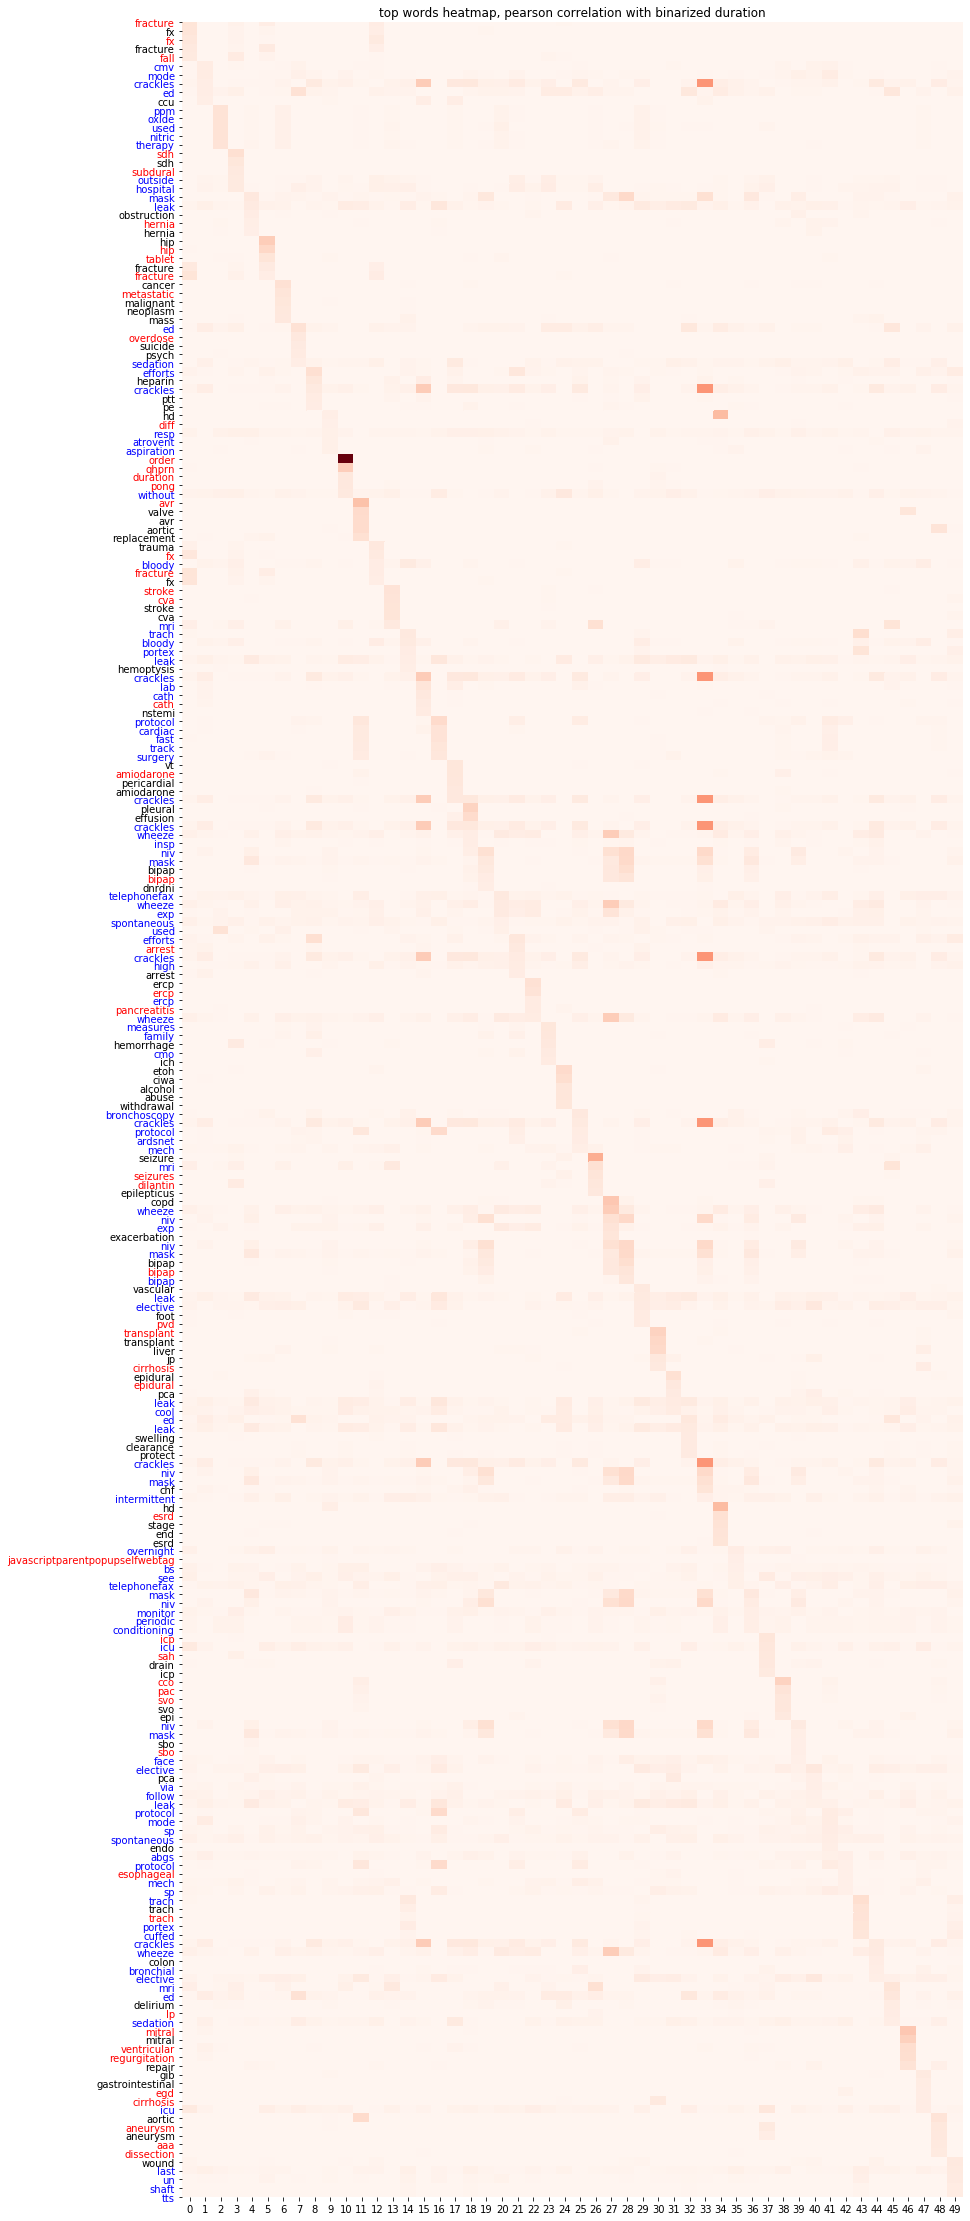

In [124]:
plt.figure(figsize=(14, 40))
sns.heatmap(word_topic_matrix.iloc[:, 2:], yticklabels=yticklabels, xticklabels=xticklabels, cmap='Reds', cbar=False)
ax = plt.gca()
for idx in range(len(ax.get_yticklabels())):
    if top_types[idx] == 1:
        ax.get_yticklabels()[idx].set_color("red")
    elif top_types[idx] == 3:
        ax.get_yticklabels()[idx].set_color("blue")
plt.title('top words heatmap, pearson correlation with binarized duration')

### Top words in each topic, using word cloud

In [105]:
from wordcloud import WordCloud

In [75]:
wordcloud = WordCloud()

In [133]:
word_cloud_dict = {str(top_words_bytopic[0].iloc[idx]) + ', ' + str(top_types_bytopic[0].iloc[idx]): phis_df[(phis_df['CATEGORY'] == top_types_bytopic[0].iloc[idx]) & \
                                                                                   (phis_df['WORD_ID'] == top_words_bytopic[0].iloc[idx])]['0'].values[0] for idx in range(5)}

In [134]:
word_cloud_dict

{'4170, 1': 0.031941000000000004,
 '3578, 2': 0.0305339,
 '4239, 1': 0.0265012,
 '3521, 2': 0.022574700000000003,
 '3851, 1': 0.022003400000000003}

In [192]:
word_by_topic.head()

,NOTE_TYPE,WORD,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,physician,aa,0.000005,0.000084,0.000005,0.000005,0.000667,0.000014,3.806320e-04,6.287730e-05,...,0.000005,0.000005,0.000381,4.968800e-06,0.000108,1.076860e-04,0.000009,5.807450e-06,0.000020,3.484980e-05
1,physician,aaa,0.000706,0.000003,0.000003,0.000003,0.000081,0.000004,2.689070e-06,2.040350e-06,...,0.000003,0.000568,0.000005,2.536710e-06,0.000707,2.542840e-06,0.000003,1.617240e-06,0.023311,3.027350e-06
2,physician,aado,0.000001,0.000022,0.000001,0.000002,0.000002,0.000001,8.329500e-07,7.487730e-07,...,0.000001,0.000001,0.000001,9.284230e-07,0.000001,7.471840e-07,0.000001,5.180200e-07,0.000002,9.525110e-07
3,physician,aao,0.000003,0.000002,0.000003,0.000003,0.000004,0.000003,1.843380e-06,1.704780e-06,...,0.000032,0.000043,0.000003,2.118200e-06,0.000113,2.125230e-06,0.000064,5.243000e-05,0.000005,2.302630e-06
4,physician,aaox,0.000025,0.000004,0.000006,0.000007,0.000007,0.000072,5.955400e-05,4.341600e-06,...,0.000326,0.000036,0.000154,1.307730e-04,0.000007,3.589600e-06,0.000008,2.620310e-06,0.000163,6.630780e-06


In [203]:
current_topic_df = word_by_topic[['NOTE_TYPE', 'WORD', '0']]
current_topic_df = current_topic_df.sort_values(by='0', ascending=False)[0:50]

In [204]:
note_type_to_color = {'physician': 'ff0000',
                     'nursing': '000000',
                     'respiratory': '0000ff'}

In [205]:
current_topic_df['COLOR'] = current_topic_df['NOTE_TYPE'].apply(lambda note_type: note_type_to_color[note_type])

In [206]:
current_topic_df

,NOTE_TYPE,WORD,0,COLOR
4170,physician,fracture,0.031941,ff0000
15488,nursing,fx,0.030534,000000
4239,physician,fx,0.026501,ff0000
15431,nursing,fracture,0.022575,000000
3851,physician,fall,0.022003,ff0000
22761,respiratory,icu,0.021369,0000ff
23586,respiratory,today,0.016744,0000ff
23746,respiratory,yes,0.015711,0000ff
15122,nursing,fall,0.014334,000000
22977,respiratory,mri,0.012977,0000ff


In [208]:
current_topic_df['0'] = current_topic_df['0'].apply(lambda value: int(1000 * value))

In [210]:
current_topic_df.drop(columns = ['NOTE_TYPE'])

,WORD,0,COLOR
4170,fracture,31,ff0000
15488,fx,30,000000
4239,fx,26,ff0000
15431,fracture,22,000000
3851,fall,22,ff0000
22761,icu,21,0000ff
23586,today,16,0000ff
23746,yes,15,0000ff
15122,fall,14,000000
22977,mri,12,0000ff


In [212]:
for topic in word_by_topic.columns[2:]:
    current_topic_df = word_by_topic[['NOTE_TYPE', 'WORD', topic]]
    current_topic_df = current_topic_df.sort_values(by=topic, ascending=False)[0:50]
    current_topic_df['COLOR'] = current_topic_df['NOTE_TYPE'].apply(lambda note_type: note_type_to_color[note_type])
    current_topic_df[topic] = current_topic_df[topic].apply(lambda value: int(1000 * value))
    current_topic_df = current_topic_df.drop(columns = ['NOTE_TYPE'])
    current_topic_df.to_csv('/home/mcb/li_lab/zwen8/data/mimic/word_cloud/' + topic + '.csv', index=None)